# Task 02: Exploratory Data Analysis (Part 3)

## Semantic & Syntactic Exploration

### Load Dataset

In [30]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
spacy.cli.download("en_core_web_sm")
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoTokenizer, AutoModel
import torch
import re
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

train_path = Path("../data/processed/pcl_task1_train.csv")
dev_path = Path("../data/processed/pcl_task1_dev.csv")

train_df = pd.read_csv(train_path)
dev_df = pd.read_csv(dev_path)

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [17]:

device = (
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)

print("Using device:", device)

Using device: mps


### Part-of-Speech (POS) Tagging

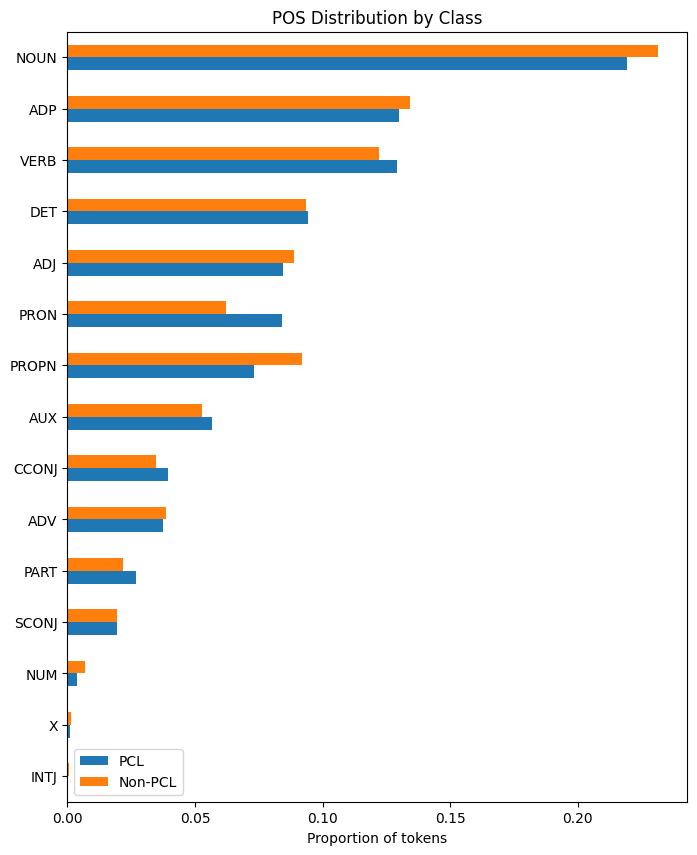

In [18]:
nlp = spacy.load("en_core_web_sm", disable=["ner"])

def pos_distribution(texts, sample=2000):
    sample = min(sample, len(texts))
    counter = Counter()
    for doc in nlp.pipe(texts.sample(sample, random_state=0), batch_size=64):
        for tok in doc:
            if tok.is_alpha:
                counter[tok.pos_] += 1
    return counter

pos_pos = pos_distribution(train_df.loc[train_df.label_bin==1, "text"])
pos_neg = pos_distribution(train_df.loc[train_df.label_bin==0, "text"])

df_pos = pd.DataFrame([pos_pos, pos_neg], index=["PCL","Non-PCL"]).T
df_pos = df_pos.div(df_pos.sum(axis=0), axis=1)  # normalize

df_pos.sort_values("PCL").plot(kind="barh", figsize=(8,10))
plt.title("POS Distribution by Class")
plt.xlabel("Proportion of tokens")
plt.show()

### Named Entity Recognition (NER)

- PCL tends to use more pronouns  (PRON), since PCL probably talks about people emotionally, not objectively
- Non-PCL tends to use more proper nouns (PROPN - named entities) which tend to relate to factual/reporting styles rather than abstract emotive language

/Users/joshuakilla/Documents/PCL-detection/venv/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


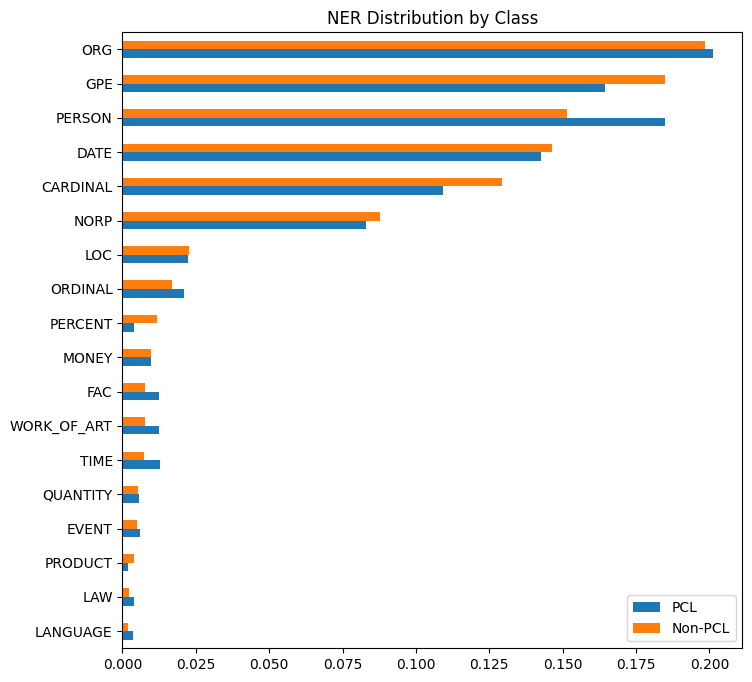

In [19]:
nlp_ner = spacy.load("en_core_web_sm", disable=["tagger","parser"])

def ner_distribution(texts, sample=2000):
    sample = min(sample, len(texts))
    counter = Counter()
    for doc in nlp_ner.pipe(texts.sample(sample, random_state=0), batch_size=32):
        for ent in doc.ents:
            counter[ent.label_] += 1
    return counter

ner_pos = ner_distribution(train_df.loc[train_df.label_bin==1, "text"])
ner_neg = ner_distribution(train_df.loc[train_df.label_bin==0, "text"])


df_ner = pd.DataFrame([ner_pos, ner_neg], index=["PCL","Non-PCL"]).T.fillna(0)
df_ner = df_ner.div(df_ner.sum(axis=0), axis=1)

df_ner.sort_values("Non-PCL").plot(kind="barh", figsize=(8,8))
plt.title("NER Distribution by Class")
plt.show()


- These lightly hint at particular styles of writing
- PERCENT and CARDINAL (quantity) are more frequent to non-PCL as these are common with facts and statistacs (objective descriptions)
- PERSON is used more in PCL - could be stories about people (framing and emotional narratives)


In [38]:
ner_labels = {"PERSON", "ORG"}
counts = {"PCL": {"PERSON": Counter(), "ORG": Counter()},
          "Non-PCL": {"PERSON": Counter(), "ORG": Counter()}}

# sample a df, keep labels aligned
sdf = train_df.sample(n=min(2000, len(train_df)), random_state=0)[["text", "label_bin"]]

# stream (text, context) into spaCy
for doc, ctx in nlp_ner.pipe(zip(sdf["text"].tolist(), sdf["label_bin"].tolist()),
                             as_tuples=True, batch_size=32):
    cls = "PCL" if ctx == 1 else "Non-PCL"
    for ent in doc.ents:
        if ent.label_ in ner_labels:
            counts[cls][ent.label_][ent.text] += 1

print("Top PERSON entities in PCL:")
print(counts["PCL"]["PERSON"].most_common(10))
print("\nTop PERSON entities in Non-PCL:")
print(counts["Non-PCL"]["PERSON"].most_common(10))
print("\nTop ORG entities in PCL:")
print(counts["PCL"]["ORG"].most_common(10))
print("\nTop ORG entities in Non-PCL:")
print(counts["Non-PCL"]["ORG"].most_common(10))

/Users/joshuakilla/Documents/PCL-detection/venv/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Top PERSON entities in PCL:
[('Ryan', 3), ('Francis', 2), ('Daraz', 2), ('Jesus', 2), ('Archibald', 1), ('Ghana', 1), ('Storm Nicole', 1), ('Rafiqul Bari', 1), ('Liz Manne', 1), ('Caroline Baron', 1)]

Top PERSON entities in Non-PCL:
[('Trump', 27), ('Donald Trump', 17), ('Wong', 6), ('James', 6), ('Obama', 6), ('Sri Lanka', 5), ('Brexit', 4), ('Sri Lankan', 4), ('Tamil', 3), ('Kelly', 3)]

Top ORG entities in PCL:
[('Congress', 2), ('UN', 2), ('UNHCR', 2), ('Carmel', 2), ('Project Warmth', 2), ('Group', 2), ('CRP', 2), ('U.K', 1), ('NRC', 1), ('the Pakistan Red Crescent Society', 1)]

Top ORG entities in Non-PCL:
[('Trump', 27), ('UN', 23), ('EU', 15), ('UNHCR', 13), ('Reuters', 11), ('Congress', 8), ('European Union', 6), ('Parliament', 5), ('ANC', 5), ('the European Union', 4)]


### Embedding Visualistion with UMAP & t-SNE

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 1419.27it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]   
DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_transform.bias    | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


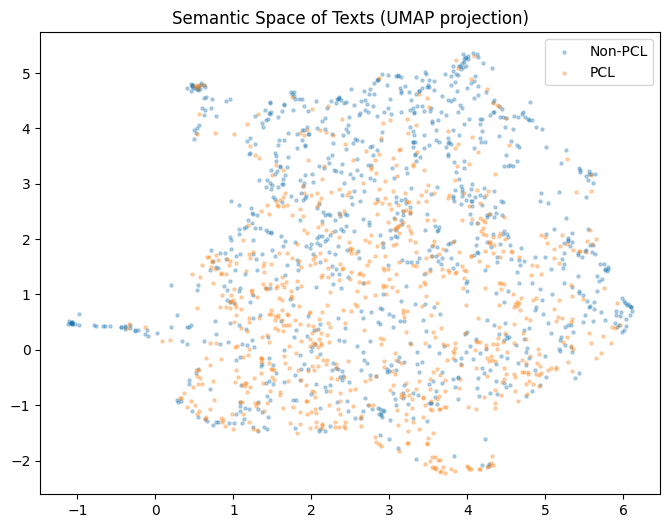

In [22]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased").to(device).eval()

def embed(texts, sample=1000):
    sample = min(sample, len(texts))
    texts = texts.sample(sample, random_state=0).tolist()
    embs = []

    with torch.no_grad():
        for i in range(0, len(texts), 32):
            batch = tokenizer(texts[i:i+32], padding=True, truncation=True, return_tensors="pt").to(device)
            out = model(**batch).last_hidden_state[:,0,:]
            embs.append(out.cpu().numpy())
    return np.vstack(embs)

pos_emb = embed(train_df.loc[train_df.label_bin==1, "text"])
neg_emb = embed(train_df.loc[train_df.label_bin==0, "text"])

X = np.vstack([pos_emb, neg_emb])
y = np.array([1]*len(pos_emb) + [0]*len(neg_emb))

proj = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(proj[y==0,0], proj[y==0,1], s=5, alpha=0.3, label="Non-PCL")
plt.scatter(proj[y==1,0], proj[y==1,1], s=5, alpha=0.3, label="PCL")
plt.legend()
plt.title("Semantic Space of Texts (UMAP projection)")
plt.show()

- PCL and Non-PCL texts overlap heavily in semantic space, showing no clear separation by topic.
- The difference lies in linguistic framing and tone rather than subject matter or keywords.
- Hence the task requires contextual understanding, which explains why transformer models outperform shallow approaches.

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 1322.11it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]   
DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_transform.bias    | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


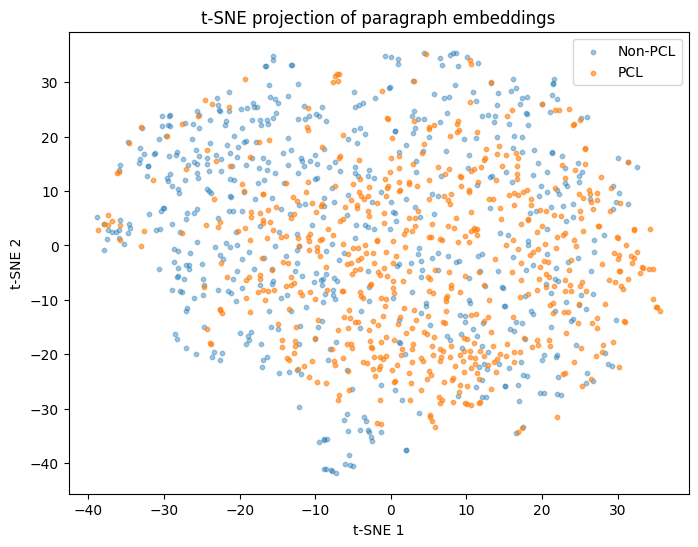

In [26]:
# balanced sample
pos_df = train_df[train_df.label_bin == 1]
neg_df = train_df[train_df.label_bin == 0]

n_pos = min(len(pos_df), 600)
n_neg = n_pos

sample_df = pd.concat([
    pos_df.sample(n_pos, random_state=0),
    neg_df.sample(n_neg, random_state=0)
]).sample(frac=1, random_state=0)   # shuffle

texts = sample_df["text"]
y = sample_df["label_bin"].to_numpy()

X = embed(texts, sample=len(texts))  # if your embed() samples internally, adjust it to accept list directly

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased").to(device).eval()

def embed_text_list(text_list, batch_size=32):
    embs = []
    with torch.no_grad():
        for i in range(0, len(text_list), batch_size):
            batch = tokenizer(text_list[i:i+batch_size], padding=True, truncation=True, return_tensors="pt").to(device)
            out = model(**batch).last_hidden_state[:, 0, :]  # CLS
            embs.append(out.cpu().numpy())
    return np.vstack(embs)

X = embed_text_list(texts.tolist())

tsne = TSNE(
    n_components=2,
    perplexity=30,       # try 10, 30, 50
    learning_rate="auto",
    init="pca",
    random_state=0
)

Z = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(Z[y==0, 0], Z[y==0, 1], s=10, alpha=0.4, label="Non-PCL")
plt.scatter(Z[y==1, 0], Z[y==1, 1], s=10, alpha=0.6, label="PCL")
plt.legend()
plt.title("t-SNE projection of paragraph embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

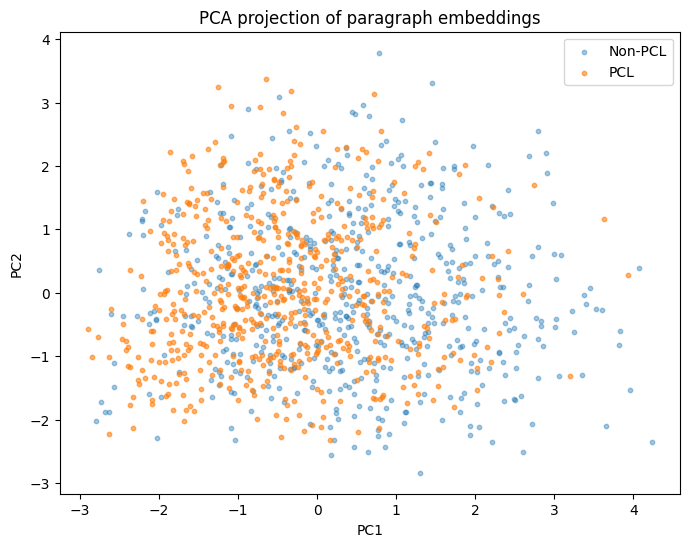

In [28]:
pca = PCA(n_components=2)
Z = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(Z[y==0,0], Z[y==0,1], s=10, alpha=0.4, label="Non-PCL")
plt.scatter(Z[y==1,0], Z[y==1,1], s=10, alpha=0.6, label="PCL")
plt.legend()
plt.title("PCA projection of paragraph embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### Word Vector PCA embeddings

In [33]:
# ---- config ----
MODEL_NAME = "distilbert-base-uncased"
N_PER_CLASS = 400          # bump to 800 if you want (slower)
MIN_OCC = 6                # min occurrences per class for a word to be kept
BATCH = 16

def simple_words(text):
    return re.findall(r"[a-z']+", text.lower())

tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME).to(device).eval()

N_PER_CLASS = min(N_PER_CLASS, min((train_df.label_bin==1).sum(), (train_df.label_bin==0).sum()))

# ---- balanced sample ----
pos_df = train_df[train_df.label_bin==1].sample(n=N_PER_CLASS, random_state=0)
neg_df = train_df[train_df.label_bin==0].sample(n=N_PER_CLASS, random_state=0)
df = pd.concat([pos_df, neg_df]).sample(frac=1, random_state=0).reset_index(drop=True)

# ---- accumulators: sum vectors + counts per word per class ----
sum_vec = {0: defaultdict(lambda: 0), 1: defaultdict(lambda: 0)}
cnt     = {0: defaultdict(int),      1: defaultdict(int)}

with torch.no_grad():
    for i in range(0, len(df), BATCH):
        batch = df.iloc[i:i+BATCH]
        ys = batch["label_bin"].to_numpy()

        words_list = [simple_words(t) for t in batch["text"].tolist()]
        enc = tok(words_list, is_split_into_words=True, padding=True, truncation=True, return_tensors="pt").to(device)
        hs = mdl(**enc).last_hidden_state  # (B, T, H)

        for bi in range(len(batch)):
            word_ids = enc.word_ids(batch_index=bi)  # maps token positions -> word index
            # group token indices by word index
            buckets = defaultdict(list)
            for ti, wid in enumerate(word_ids):
                if wid is not None:
                    buckets[wid].append(ti)

            y = int(ys[bi])
            for wid, token_idxs in buckets.items():
                w = words_list[bi][wid]
                v = hs[bi, token_idxs, :].mean(dim=0).detach().cpu().numpy()
                sum_vec[y][w] = sum_vec[y][w] + v
                cnt[y][w] += 1

# ---- build difference vectors (mean(PCL) - mean(Non-PCL)) ----
common = [w for w in set(cnt[0]) & set(cnt[1]) if cnt[0][w] >= MIN_OCC and cnt[1][w] >= MIN_OCC]
Xdiff = np.vstack([(sum_vec[1][w]/cnt[1][w]) - (sum_vec[0][w]/cnt[0][w]) for w in common])

pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(Xdiff)

pca_df = pd.DataFrame({"word": common, "pc1": Z[:,0], "pc2": Z[:,1]})
pca_df.head()

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 1872.88it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]   
DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_transform.bias    | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


,word,pc1,pc2
0,education,-0.039723,0.270169
1,i,0.235515,-0.031061
2,benefit,0.105928,0.968686
3,support,0.140947,0.388949
4,could,0.318520,-0.210529


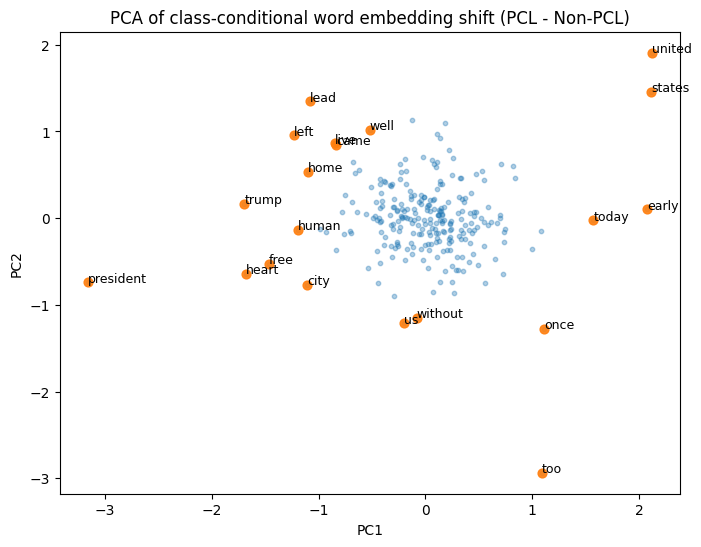

,word,shift
0,president,3.243447
1,too,3.130917
2,united,2.849358
3,states,2.568593
4,early,2.075736
5,heart,1.793509
6,lead,1.727164
7,trump,1.701553
8,once,1.691697
9,today,1.572504


In [34]:
# Which words have the biggest shift in embedding space between PCL and Non-PCL contexts?
pca_df["shift"] = np.sqrt(pca_df.pc1**2 + pca_df.pc2**2)
top = pca_df.sort_values("shift", ascending=False).head(20)

plt.figure(figsize=(8,6))
plt.scatter(pca_df.pc1, pca_df.pc2, s=10, alpha=0.35)
plt.scatter(top.pc1, top.pc2, s=40, alpha=0.9)

for _, r in top.iterrows():
    plt.text(r.pc1, r.pc2, r.word, fontsize=9)

plt.title("PCA of class-conditional word embedding shift (PCL - Non-PCL)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

top[["word","shift"]].reset_index(drop=True)

In [35]:
# Build paired embeddings (mean per class)
words = [w for w in common if cnt[0][w] >= MIN_OCC and cnt[1][w] >= MIN_OCC]

emb_non = np.vstack([sum_vec[0][w]/cnt[0][w] for w in words])
emb_pcl = np.vstack([sum_vec[1][w]/cnt[1][w] for w in words])

# Combine and project together
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(np.vstack([emb_non, emb_pcl]))

Z_non = Z[:len(words)]
Z_pcl = Z[len(words):]

# choose words with biggest movement
movement = np.linalg.norm(Z_pcl - Z_non, axis=1)
top_idx = np.argsort(-movement)[:20]

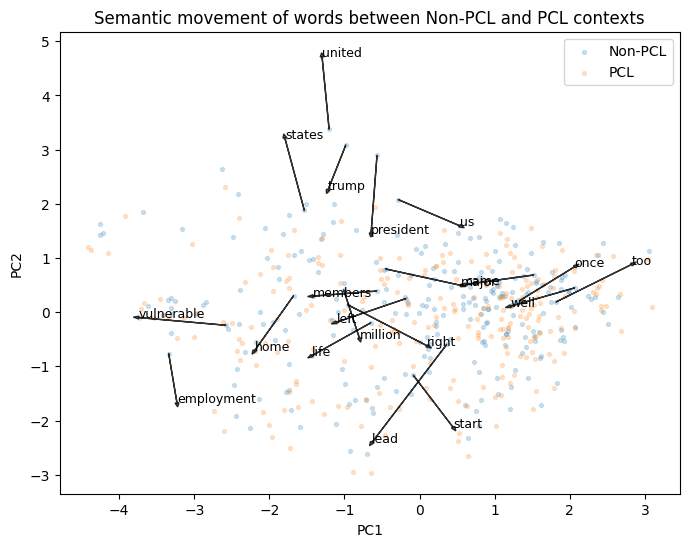

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# plot all words faintly
plt.scatter(Z_non[:,0], Z_non[:,1], s=8, alpha=0.2, label="Non-PCL")
plt.scatter(Z_pcl[:,0], Z_pcl[:,1], s=8, alpha=0.2, label="PCL")

# arrows for most shifting words
for i in top_idx:
    x1,y1 = Z_non[i]
    x2,y2 = Z_pcl[i]
    plt.arrow(x1,y1, x2-x1, y2-y1,
              head_width=0.05, alpha=0.8)
    plt.text(x2,y2, words[i], fontsize=9)

plt.legend()
plt.title("Semantic movement of words between Non-PCL and PCL contexts")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### PCL Categories Analysis wrt Binary Classification